# RANDOM FOREST MODEL BUILD

In [19]:
# Import Required Libraries
import time
import psutil  # For system performance tracking
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


## Load Train and Test Datasets

In [20]:
#  Load NSL-KDD Dataset
df_train = pd.read_csv('../../2_Modeling-Phase/train_and_test_datasets/NSL-KDD/train.csv')
df_test = pd.read_csv('../../2_Modeling-Phase/train_and_test_datasets/NSL-KDD/test.csv')

#  Separate Features & Target
X_train = df_train.drop(['binary_attack'], axis=1)
y_train = df_train['binary_attack']

X_test = df_test.drop(['binary_attack'], axis=1)
y_test = df_test['binary_attack']

# Split Training Data for Validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Track Computational Overhead (Before Training)

In [21]:
#  Measure Initial System Performance
cpu_before = psutil.cpu_percent(interval=None)
memory_before = psutil.virtual_memory().used / (1024 * 1024)  # Convert to MB
disk_before = psutil.disk_io_counters().read_bytes / (1024 * 1024)  # Convert to MB

# Start Timer for Training
training_start_time = time.time()

## Model Creation and Training

In [22]:
# Initialize and Train Random Forest Classifier
rf_model = RandomForestClassifier(
                n_estimators=200, 
                max_depth=20, 
                min_samples_split=5, 
                min_samples_leaf=2, 
            #     max_features='sqrt', 
                random_state=42)

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# End Timer for Training
training_end_time = time.time()
execution_time = training_end_time - training_start_time

# Evaluate Model Performance

In [23]:
#  Compute Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\n🔍 **Model Performance Metrics:**")
print(f"✅ **Accuracy:** {accuracy:.2%}")
print(f"✅ **Precision:** {precision:.2%}")
print(f"✅ **Recall:** {recall:.2%}")
print(f"✅ **F1-score:** {f1:.2%}")


🔍 **Model Performance Metrics:**
✅ **Accuracy:** 82.59%
✅ **Precision:** 72.09%
✅ **Recall:** 97.24%
✅ **F1-score:** 82.80%


# Measure Computational Overhead (After Training)

In [24]:
#  Track System Metrics AFTER Training
cpu_after = psutil.cpu_percent(interval=None)
memory_after = psutil.virtual_memory().used / (1024 * 1024)
disk_after = psutil.disk_io_counters().read_bytes / (1024 * 1024)

#  Compute Overhead Metrics
cpu_usage_change = cpu_after - cpu_before
memory_used = memory_after - memory_before
disk_io_used = disk_after - disk_before

print("\n🚀 **Computational Overhead Report** 🚀")
print(f"⏳ **Training Execution Time:** {execution_time:.4f} seconds")
print(f"🔥 **CPU Usage Change:** {cpu_usage_change:.2f}%")
print(f"💾 **Disk I/O Usage:** {disk_io_used:.2f} MB")
print(f"📊 **Peak Memory Usage:** {memory_used:.2f} MB")



🚀 **Computational Overhead Report** 🚀
⏳ **Training Execution Time:** 13.3735 seconds
🔥 **CPU Usage Change:** 2.60%
💾 **Disk I/O Usage:** 2.75 MB
📊 **Peak Memory Usage:** -9.44 MB


# Extract Feature Importance (Gini Importance)

In [43]:
# Extract feature importance
feature_importance = rf_model.feature_importances_

# Convert to DataFrame
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display Top Features
print("Top 10 Important Features:\n", importance_df.head(14))


Top 10 Important Features:
                      Feature  Importance
4                  src_bytes    0.176335
5                  dst_bytes    0.113163
28             same_srv_rate    0.081293
41                     level    0.067184
33    dst_host_same_srv_rate    0.064912
29             diff_srv_rate    0.062584
3                       flag    0.055071
11                 logged_in    0.042574
22                     count    0.037175
1              protocol_type    0.033860
32        dst_host_srv_count    0.030891
34    dst_host_diff_srv_rate    0.026206
24               serror_rate    0.025947
38  dst_host_srv_serror_rate    0.025526


# Visualizing Feature Importance

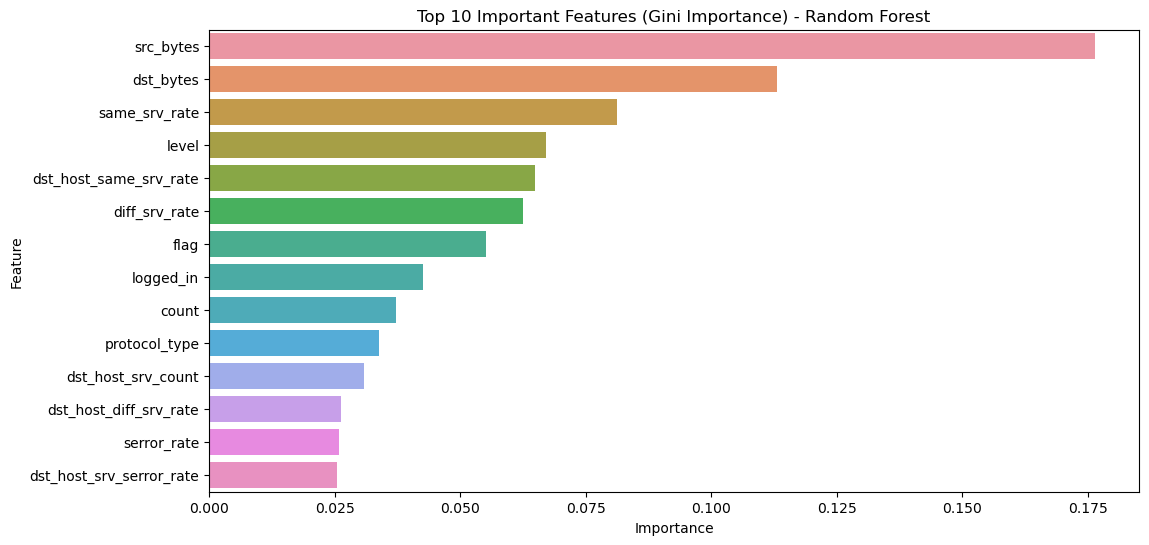

In [44]:
# Plot the top 10 important features
plt.figure(figsize=(12, 6))
sns.barplot(x=importance_df['Importance'][:14], y=importance_df['Feature'][:14])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features (Gini Importance) - Random Forest')
plt.show()

# Select Top Features and Retrain the Model

In [45]:
# Select top 10 important features
top_features = importance_df['Feature'][:14].values

# Reduce dataset to selected features
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]


# Retrain Random Forest on Selected Features

In [46]:
# Train a new Random Forest using only selected features
rf_selected_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=30,
    min_samples_split=15,
    min_samples_leaf=10,
    random_state=42
)

rf_selected_model.fit(X_train_selected, y_train)


RandomForestClassifier(max_depth=30, min_samples_leaf=10, min_samples_split=15,
                       n_estimators=300, random_state=42)

# Measure Inference Overhead

In [47]:
#  Start Timer for Inference
inference_start_time = time.time()

#  Make Predictions on Test Data
y_pred = rf_model.predict(X_test)

#  End Timer for Inference
inference_end_time = time.time()
total_inference_time = inference_end_time - inference_start_time

#  Compute Inference Time per Sample
inference_time = total_inference_time / len(X_test)

print(f"🕒 **Total Inference Time:** {total_inference_time:.4f} seconds")
print(f"⚡ **Inference Time per Sample:** {inference_time:.6f} seconds")


🕒 **Total Inference Time:** 0.2671 seconds
⚡ **Inference Time per Sample:** 0.000012 seconds


# Evaluate Model Performance

In [48]:
# Predict on test set
y_test_pred_selected = rf_selected_model.predict(X_test_selected)

# Compute accuracy
test_accuracy_selected = accuracy_score(y_test, y_test_pred_selected)
test_precision_selected = precision_score(y_test, y_test_pred_selected)
test_recall_selected = recall_score(y_test, y_test_pred_selected)
test_f1_selected = f1_score(y_test, y_test_pred_selected)

print("\nTest Metrics (Using Selected Features):")
print(f"Accuracy:   {test_accuracy_selected:.2%}")
print(f"Precision:  {test_precision_selected:.2%}")
print(f"Recall:     {test_recall_selected:.2%}")
print(f"F1-score:   {test_f1_selected:.2%}")



Test Metrics (Using Selected Features):
Accuracy:   82.89%
Precision:  72.50%
Recall:     97.11%
F1-score:   83.02%


# Plot Confusion Matrix

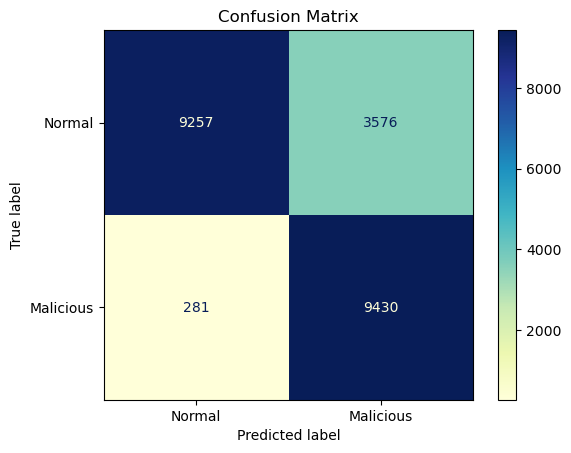

              precision    recall  f1-score   support

           0       0.97      0.72      0.83     12833
           1       0.73      0.97      0.83      9711

    accuracy                           0.83     22544
   macro avg       0.85      0.85      0.83     22544
weighted avg       0.86      0.83      0.83     22544



In [49]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(y_test, y_test_pred_selected).astype(int)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Malicious'])

disp.plot(cmap='YlGnBu', values_format='d')

plt.title('Confusion Matrix')
plt.show()


# Classification report
print(classification_report(y_test, y_test_pred_selected))

In [50]:
num_trees = len(rf_selected_model.estimators_)

print("\n🚀 **Computational Overhead Report** 🚀")
print(f"⏳ **Execution Time:** {execution_time:.4f} seconds")
print(f"🔥 **CPU Usage Change:** {cpu_usage_change:.2f}%")
print(f"💾 **Disk I/O Usage:** {disk_io_used:.2f} MB")
print(f"📊 **Peak Memory Usage:** {memory_used:.2f} MB")
print(f"🌳 **Random Forest Complexity:**")
print(f"🌲 **Number of Trees:** {num_trees}")



🚀 **Computational Overhead Report** 🚀
⏳ **Execution Time:** 13.3735 seconds
🔥 **CPU Usage Change:** 2.60%
💾 **Disk I/O Usage:** 2.75 MB
📊 **Peak Memory Usage:** -9.44 MB
🌳 **Random Forest Complexity:**
🌲 **Number of Trees:** 300


# Save the Trained Model

In [51]:
# Save the trained model
model_folder = "../../3_Post-Modeling-Phase/Trained_ML_models/Models-NSL-KDD/"
model_filename = "NSL-KDD_RandomForest.joblib"
model_path = model_folder + model_filename


joblib.dump(rf_selected_model, model_path)
print(f"Random Forest model saved to: {model_path}")

Random Forest model saved to: ../../3_Post-Modeling-Phase/Trained_ML_models/Models-NSL-KDD/NSL-KDD_RandomForest.joblib
